In [1]:
import os
import numpy as np
import astropy.table as aTable

In [2]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read in FEMA+FSF+CENSUS in (zipcode, year, month)

In [3]:
fema = aTable.Table.read('/Users/chahah/data/noah/fema.zipcode.fsf.acs.csv', format='csv')
# only keep entries after 1990 (CRS started after 1990 also no rainfall data before 1990)
fema = fema[fema['yearOfLoss'] >= 1990]
print(len(fema))

142887


In [4]:
fema[:5]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10,2018.population,2018.median_household_income,2018.renter_fraction,2018.educated_fraction,2014.population,2014.median_household_income,2014.renter_fraction,2014.educated_fraction,2010.population,2010.median_household_income,2010.renter_fraction,2010.educated_fraction
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64
1001,2005,10,MA,-72.6,42.1,0.0,11.0,0.6666666666666666,3.0,5958.55,0.0,455800,26400,5958.55,482200,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175
1001,2014,8,MA,-72.6,42.1,0.0,11.0,1.0,1.0,590.26,0.0,250000,100000,590.26,350000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175
1001,2011,8,MA,-72.6,42.1,0.0,11.0,1.0,2.0,9320.56,0.0,262000,5000,9320.56,267000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175
1001,2011,4,MA,-72.6,42.0,0.0,11.0,1.0,1.0,10545.77,1473.46,250000,100000,12019.23,350000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175
1002,1991,8,MA,-70.6,41.7,0.0,11.0,0.0,1.0,33851.0,0.0,70000,0,33851.0,70000,1002,7048,80,1.1,194,2.8,204,2.9,497,7.1,513,7.3,654,9.3,670,9.5,5.9,1.53,6.6,7.61,6.7,5.9,1.48,6378,15,53,87,34,172,94,14,98,103,30099,60540,0.4102129638858434,0.7107991817732948,29970,48923,0.4468134801468135,0.65777009247425,28718,56175,0.3966153631868515,0.6823411319589221


## read in rainfall data in (zipcode, year, month)

In [5]:
rainfall = aTable.Table.read('/Users/chahah/data/noah/rainfall_PRISM.zipcode_year_month.csv', format='csv')
print(len(rainfall))

10203216


In [6]:
rainfall.rename_column('ZIP_CODE', 'reportedZipcode')
rainfall.rename_column('year', 'yearOfLoss')
rainfall.rename_column('month', 'monthOfLoss')
rainfall.rename_column('MEAN', 'mean_rainfall')
rainfall.rename_column('SUM', 'sum_rainfall')
rainfall.rename_column('MEDIAN', 'median_rainfall')

In [7]:
rainfall[:5]

reportedZipcode,AREA,mean_rainfall,sum_rainfall,median_rainfall,yearOfLoss,monthOfLoss
int64,float64,float64,float64,float64,int64,int64
12,0.010416666666683332,138.89550018310547,833.3730010986328,138.85299682617188,1990,1
14,0.30208333333381665,19.77479310967456,3440.8140010833736,17.080500602722168,1990,1
15,0.010416666666683332,25.514833450317383,153.0890007019043,25.559499740600586,1990,1
16,0.006944444444455555,67.29499912261963,269.1799964904785,66.83699798583984,1990,1
17,0.14756944444468054,153.66114115995518,13061.19699859619,153.44900512695312,1990,1


In [8]:
comb = aTable.join(fema, rainfall, keys=['reportedZipcode', 'yearOfLoss', 'monthOfLoss'], join_type='left')

In [9]:
comb[:5]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10,2018.population,2018.median_household_income,2018.renter_fraction,2018.educated_fraction,2014.population,2014.median_household_income,2014.renter_fraction,2014.educated_fraction,2010.population,2010.median_household_income,2010.renter_fraction,2010.educated_fraction,AREA,mean_rainfall,sum_rainfall,median_rainfall
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
1001,2005,10,MA,-72.6,42.1,0.0,11.0,0.6666666666666666,3.0,5958.55,0.0,455800,26400,5958.55,482200,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175,0.005208333333341666,321.2156677246094,963.6470031738281,312.2799987792969
1001,2011,4,MA,-72.6,42.0,0.0,11.0,1.0,1.0,10545.77,1473.46,250000,100000,12019.23,350000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175,0.005208333333341666,147.1486612955729,441.44598388671875,147.62399291992188
1001,2011,8,MA,-72.6,42.1,0.0,11.0,1.0,2.0,9320.56,0.0,262000,5000,9320.56,267000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175,0.005208333333341666,266.2306620279948,798.6919860839844,266.02899169921875
1001,2014,8,MA,-72.6,42.1,0.0,11.0,1.0,1.0,590.26,0.0,250000,100000,590.26,350000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175,0.005208333333341666,99.75433349609375,299.26300048828125,101.04000091552734
1002,1991,8,MA,-70.6,41.7,0.0,11.0,0.0,1.0,33851.0,0.0,70000,0,33851.0,70000,1002,7048,80,1.1,194,2.8,204,2.9,497,7.1,513,7.3,654,9.3,670,9.5,5.9,1.53,6.6,7.61,6.7,5.9,1.48,6378,15,53,87,34,172,94,14,98,103,30099,60540,0.4102129638858434,0.7107991817732948,29970,48923,0.4468134801468135,0.65777009247425,28718,56175,0.3966153631868515,0.6823411319589221,0.01388888888891111,233.21237564086914,1865.69900

In [10]:
print('%i of %i entries do not have rainfall data' % (np.sum(comb['AREA'].mask), len(comb)))
print('%.2f percent' % (100*np.mean(comb['AREA'].mask)))

15352 of 142887 entries do not have rainfall data
10.74 percent


### check why they don't have rainfall data

In [11]:
comb[comb['AREA'].mask]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10,2018.population,2018.median_household_income,2018.renter_fraction,2018.educated_fraction,2014.population,2014.median_household_income,2014.renter_fraction,2014.educated_fraction,2010.population,2010.median_household_income,2010.renter_fraction,2010.educated_fraction,AREA,mean_rainfall,sum_rainfall,median_rainfall
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
1053,1999,9,MA,-72.7,42.3,1.0,8.0,1.0,1.0,7408.23,5059.3,132800,10000,12467.529999999999,142800,1053,543,12,2.2,24,4.4,28,5.2,106,19.5,108,19.9,122,22.5,123,22.7,17.3,2.38,7.09,7.6,7.13,6.75,2.28,420,1,4,10,1,27,40,5,19,16,1850,50357,0.09081081081081081,0.45260663507109006,1697,66528,0.18444313494401884,0.4457652303120357,1926,67031,0.13707165109034267,0.3587736464448793,--,--,--,--
1053,2007,4,MA,-72.7,42.3,1.0,8.0,1.0,1.0,8023.01,1827.15,250000,22100,9850.16,272100,1053,543,12,2.2,24,4.4,28,5.2,106,19.5,108,19.9,122,22.5,123,22.7,17.3,2.38,7.09,7.6,7.13,6.75,2.28,420,1,4,10,1,27,40,5,19,16,1850,50357,0.09081081081081081,0.45260663507109006,1697,66528,0.18444313494401884,0.4457652303120357,1926,67031,0.13707165109034267,0.3587736464448793,--,--,--,--
1053,2011,8,MA,-72.7,42.3,1.0,8.0,1.0,1.0,18639.23,1634.77,230000,22100,20274.0,252100,1053,543,12,2.2,24,4.4,28,5.2,106,19.5,108,19.9,122,22.5,123,22.7,17.3,2.38,7.09,7.6,7.13,6.75,2.28,420,1,4,10,1,27,40,5,19,16,1850,50357,0.09081081081081081,0.45260663507109006,1697,66528,0.18444313494401884,0.4457652303120357,1926,67031,0.13707165109034267,0.3587736464448793,--,--,--,--
1105,1991,8,MA,-72.6,42.1,0.0,11.0,0.0,1.0,14300.0,2700.0,14300,2700,17000.0,17000,1105,1929,7,0.4,16,0.8,17,0.9,408,21.2,431,22.3,662,34.3,674,34.9,20.8,2.19,4.41,5.14,4.39,8.0,2.17,1255,13,213,251,3,139,23,2,20,10,12651,21875,0.8555054936368667,0.11703102500327268,11576,16455,0.8366447823082239,0.10468951670729959,12664,18008,0.8463360707517372,0.0936267071320182,--,--,--,--
1105,2008,8,MA,-72.6,42.1,0.0,11.0,0.0,1.0,1701.06,0.0,500000,500000,1701.06,1000000,1105,1929,7,0.4,16,0.8,17,0.9,408,21.2,431,22.3,662,34.3,674,34.9,20.8,2.19,4.41,5.14,4.39,8.0,2.17,1255,13,213,251,3,139,23,2,20,10,12651,21875,0.8555054936368667,0.11703102500327268,11576,16455,0.8366447823082239,0.10468951670729959,12664,18008,0.8463360707517372,0.0936267071320182,--,--,--,--
1118,1991,8,MA,-70.7,41.7,0.0,11.0,1.0,1.0,9390.37,4765.0,87900,12200,14155.37,100100,1118,5475,10,0.2,5,0.1,5,0.1,209,3.8,232,4.2,413,7.5,427,7.8,3.6,1.31,4.95,6.14,5.05,4.6,1.3,5048,15,55,120,28,179,22,4,2,2,14839,70296,0.22757598220904374,0.30152784622966977,14293,60295,0.24053732596375849,0.30613472333600644,13762,61488,0.1770091556459817,0.26391308803935637,--,--,--,--


In [12]:
uniq_zipcode_rainfall = np.unique(rainfall['reportedZipcode'])

In [13]:
in_rainfall = []
for zc in np.unique(comb['reportedZipcode'][comb['AREA'].mask]): 
    in_rainfall.append(zc in uniq_zipcode_rainfall)
print(np.sum(in_rainfall))

0


(20.0, 50.0)

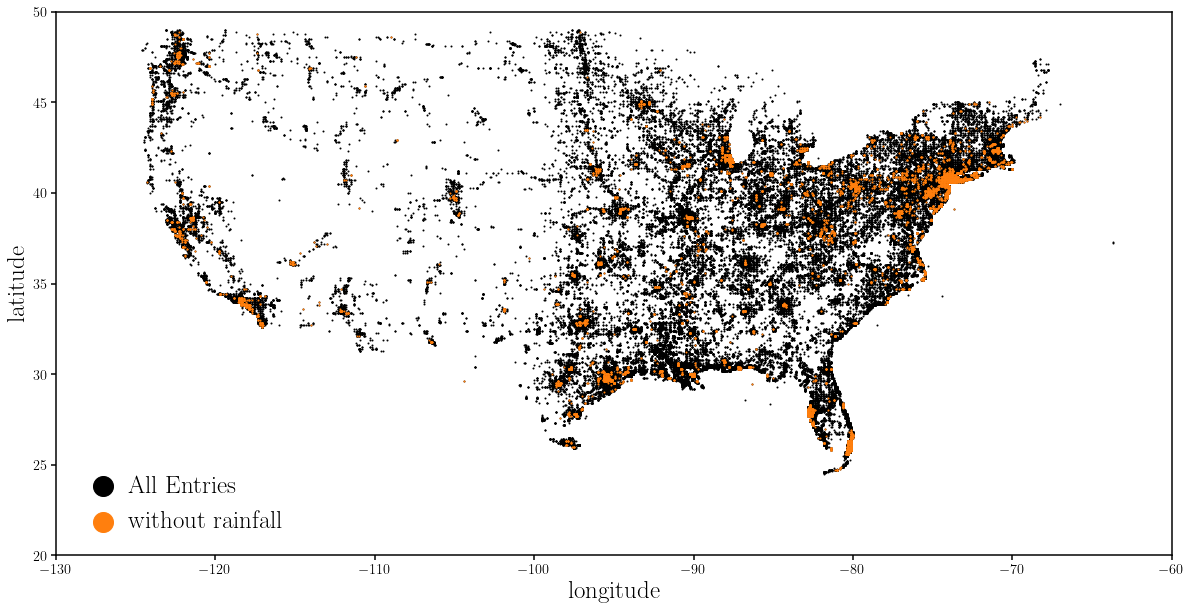

In [14]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
sub.scatter(comb['longitude'], comb['latitude'], s=1, c='k', rasterized=True, label='All Entries')
sub.scatter(comb['longitude'][comb['AREA'].mask], comb['latitude'][comb['AREA'].mask], s=1, c='C1', rasterized=True, label='without rainfall')
sub.legend(loc='lower left', markerscale=20, handletextpad=0., fontsize=25)
sub.set_xlabel('longitude', fontsize=25)
sub.set_xlim(-130., -60)
sub.set_ylabel('latitude', fontsize=25)
sub.set_ylim(20, 50)

(25.0, 35.0)

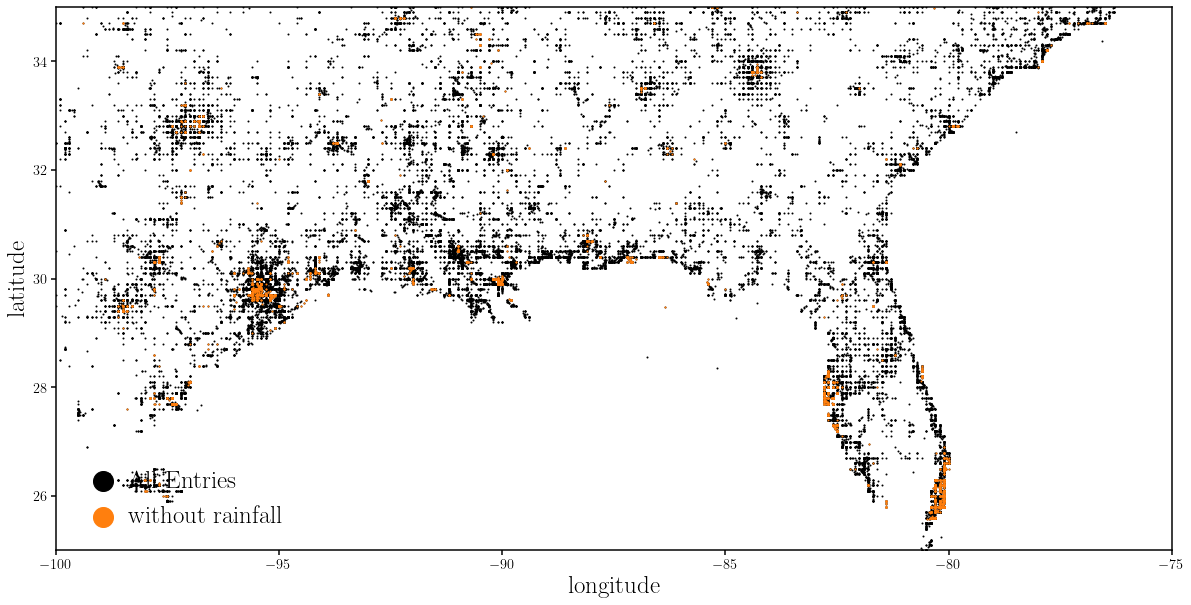

In [15]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
sub.scatter(comb['longitude'], comb['latitude'], s=1, c='k', rasterized=True, label='All Entries')
sub.scatter(comb['longitude'][comb['AREA'].mask], comb['latitude'][comb['AREA'].mask], s=1, c='C1', rasterized=True, label='without rainfall')
sub.legend(loc='lower left', markerscale=20, handletextpad=0., fontsize=25)
sub.set_xlabel('longitude', fontsize=25)
sub.set_xlim(-100., -75)
sub.set_ylabel('latitude', fontsize=25)
sub.set_ylim(25, 35)

Entries without rainfall data is because the PRISM rainfall zipcode data does not have the zipcodes

In [16]:
combined = comb[~comb['AREA'].mask]

In [17]:
combined.write('/Users/chahah/data/noah/fema.zipcode.fsf.acs.rainfall.csv', format='csv', overwrite=True)